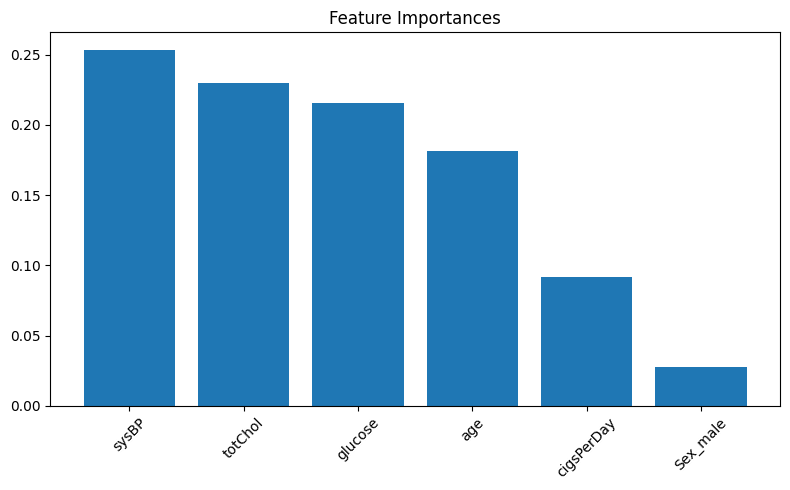

IntSlider(value=50, description='Age', max=80, min=30)

Dropdown(description='Sex', options=(('Female', 0), ('Male', 1)), value=0)

IntSlider(value=10, description='Cigs/Day', max=50)

IntSlider(value=200, description='Cholesterol', max=400, min=100)

IntSlider(value=120, description='Sys BP', max=200, min=90)

IntSlider(value=100, description='Glucose', max=200, min=60)

Button(description='Predict CHD Risk', style=ButtonStyle())

Button(description='Reset', style=ButtonStyle())

Output()

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import ipywidgets as widgets
from IPython.display import display, clear_output

# Load dataset
df = pd.read_csv("/kaggle/input/framingham-heart-attack-data/framingham.csv") 
df.drop(columns=['education'], inplace=True)
df.rename(columns={'male': 'Sex_male'}, inplace=True)
df.dropna(inplace=True)

# Prepare data
X = df[['age', 'Sex_male', 'cigsPerDay', 'totChol', 'sysBP', 'glucose']]
y = df['TenYearCHD']

scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
accuracy = accuracy_score(y_test, model.predict(X_test))

# Feature importance plot
def plot_feature_importance(model, feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(8, 5))
    plt.title("Feature Importances")
    plt.bar(range(len(importances)), importances[indices], align="center")
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
    plt.tight_layout()
    plt.show()

plot_feature_importance(model, X.columns)

# Widgets
age = widgets.IntSlider(value=50, min=30, max=80, description='Age')
sex = widgets.Dropdown(options=[('Female', 0), ('Male', 1)], description='Sex')
cigs = widgets.IntSlider(value=10, min=0, max=50, description='Cigs/Day')
chol = widgets.IntSlider(value=200, min=100, max=400, description='Cholesterol')
bp = widgets.IntSlider(value=120, min=90, max=200, description='Sys BP')
glucose = widgets.IntSlider(value=100, min=60, max=200, description='Glucose')
button = widgets.Button(description="Predict CHD Risk")
reset_button = widgets.Button(description="Reset")
output = widgets.Output()
gauge = widgets.FloatProgress(value=0.0, min=0.0, max=1.0, description='Risk Level:', bar_style='info')

# Session log
log_df = pd.DataFrame(columns=['Age', 'Sex_male', 'Cigs/Day', 'Cholesterol', 'Sys BP', 'Glucose', 'Prediction', 'Probability'])

# Callback function
def predict_chd(b):
    input_dict = {
        'age': [age.value],
        'Sex_male': [sex.value],
        'cigsPerDay': [cigs.value],
        'totChol': [chol.value],
        'sysBP': [bp.value],
        'glucose': [glucose.value]
    }
    input_df = pd.DataFrame(input_dict)
    input_scaled = scaler.transform(input_df)
    prediction = model.predict(input_scaled)[0]
    prediction_proba = model.predict_proba(input_scaled)[0][1]

    global log_df
    log_df = pd.concat([log_df, pd.DataFrame({
        'Age': [age.value],
        'Sex_male': [sex.value],
        'Cigs/Day': [cigs.value],
        'Cholesterol': [chol.value],
        'Sys BP': [bp.value],
        'Glucose': [glucose.value],
        'Prediction': [prediction],
        'Probability': [prediction_proba]
    })], ignore_index=True)

    with output:
        output.clear_output()
        print(f"✅ Model Accuracy: {accuracy:.2f}")
        gauge.value = prediction_proba
        if prediction == 1:
            est_age = age.value + 10
            gauge.bar_style = 'danger'
            print(f"🔴 High risk of CHD.")
            print(f"Estimated age of development: {est_age} years.")
            print(f"Chance of heart attack at that age: {prediction_proba * 100:.2f}%")
        else:
            gauge.bar_style = 'success'
            print("🟢 No CHD, you are safe.")
        display(gauge)

# Reset function
def reset_inputs(b):
    age.value = 50
    sex.value = 1
    cigs.value = 10
    chol.value = 200
    bp.value = 120
    glucose.value = 100
    gauge.value = 0.0
    gauge.bar_style = 'info'
    output.clear_output()

# Attach callbacks
button.on_click(predict_chd)
reset_button.on_click(reset_inputs)

# Display interface
display(age, sex, cigs, chol, bp, glucose, button, reset_button, output)
